In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [7]:
# Laod the data
df=pd.read_csv("autoready.csv")
df.head(10)

,STATE,CLASS,GENDER,AGE,PAID
0,10.0,6.0,1.0,97,1134.44
1,11.0,6.0,1.0,96,3761.24
2,11.0,1.0,1.0,95,7842.31
3,11.0,15.0,0.0,95,2384.67
4,11.0,15.0,1.0,95,650.00
5,11.0,15.0,1.0,95,391.12
6,11.0,1.0,1.0,94,3775.83
7,6.0,6.0,1.0,94,415.35
8,10.0,1.0,1.0,93,2283.56
9,2.0,1.0,1.0,93,665.48


In [6]:
# Next, we train test split keeping the same distribution wrt 'PAID'

In [8]:
X=df.drop(columns=['PAID'])
y=df['PAID']

# Bin continuous y into 10 quantiles
y_binned = np.floor(np.percentile(y, np.linspace(0, 100, 11))[:-1])
y_strat = np.digitize(y, bins=y_binned)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,  stratify=y_strat)
print(X_train.shape, X_test.shape)

(5418, 4) (1355, 4)


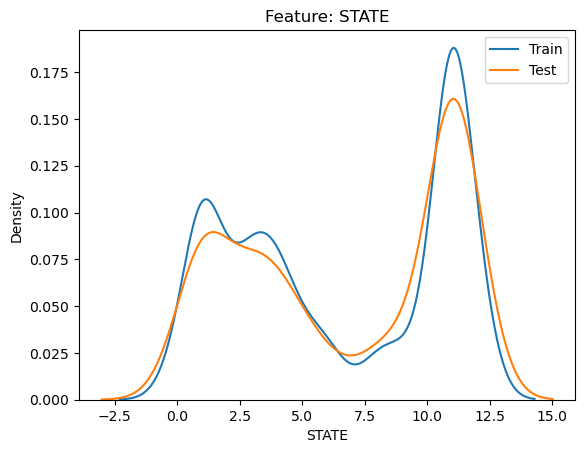

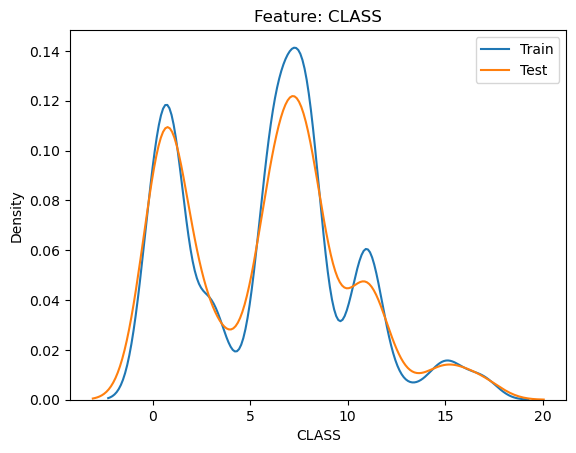

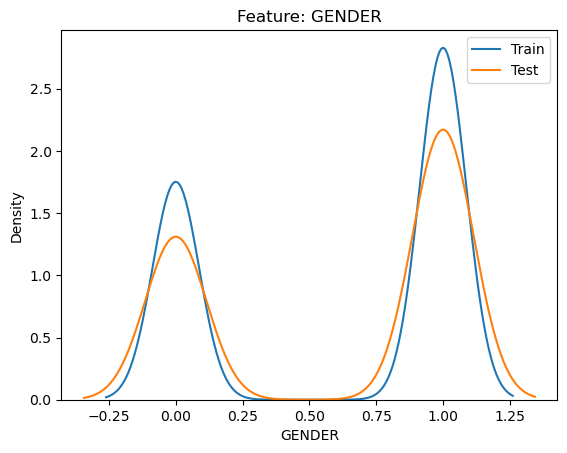

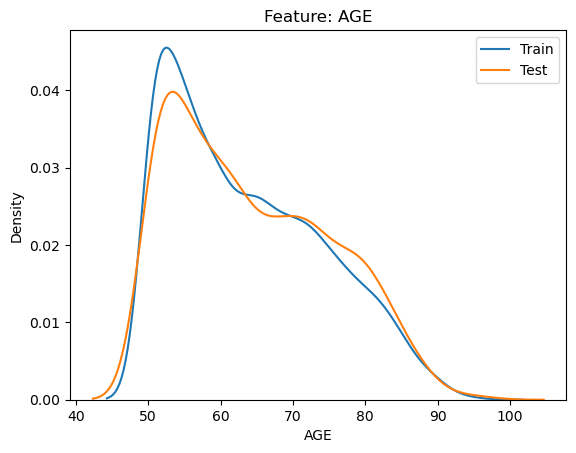

In [9]:
import seaborn as sns
for col in list(X.columns):
    sns.kdeplot(X_train[col], label='Train')
    sns.kdeplot(X_test[col], label='Test')
    plt.title(f"Feature: {col}")
    plt.legend()
    plt.show()

In [12]:
from scipy.stats import ks_2samp

for col in list(X.columns):
    stat, p = ks_2samp(X_train[col], X_test[col])
    print(f"{col}: KS test p-value = {p}")

STATE: KS test p-value = 0.06384396114366397
CLASS: KS test p-value = 0.31254737436981245
GENDER: KS test p-value = 0.999999999997914
AGE: KS test p-value = 0.1343656066032503


### Linear regression

In [17]:
from sklearn.linear_model import LinearRegression

# Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluation
print("🔹 Linear Regression")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("MAE", mean_absolute_error(y_test, y_pred_lr))
print("R2 Score:", r2_score(y_test, y_pred_lr))

🔹 Linear Regression
RMSE: 2424.0038021202413
MAE 1500.4345290974213
R2 Score: -0.0013756329915881604


### Decision trees

In [91]:
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor(
    criterion='squared_error',     # or 'friedman_mse', 'absolute_error'
    splitter='best',              # 'best' or 'random'
    max_depth=2,                 # limit depth to avoid overfitting
    min_samples_split=10,         # minimum samples required to split
    min_samples_leaf=5,           # minimum samples in each leaf node
    max_features='sqrt',          # number of features to consider per split
    random_state=42
)

tree_model.fit(X_train, y_train)

# Predictions
y_pred_tree = tree_model.predict(X_test)

# Evaluation
print("🔹 Decision Tree Regressor")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_tree)))
print("MAE", mean_absolute_error(y_test, y_pred_tree))
print("R2 Score:", r2_score(y_test, y_pred_tree))

🔹 Decision Tree Regressor
RMSE: 2422.133334299513
MAE 1498.11809337103
R2 Score: 0.00016918161308732138


### XGBoost

In [40]:
from xgboost import XGBRegressor

# Model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.001, random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
print("🔹 XGBoost Regressor")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("MAE", mean_absolute_error(y_test, y_pred_lr))
print("R2 Score:", r2_score(y_test, y_pred_xgb))

🔹 XGBoost Regressor
RMSE: 2423.078896129439
MAE 1500.4345290974213
R2 Score: -0.0006116064465016002


### Neural Netwroks

In [69]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import StandardScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define input shape
input_shape = X_train.shape[1]

# Build the model
model = models.Sequential([
    layers.Input(shape=(input_shape,)),
    layers.Dense(500, activation='gelu'),
    layers.Dense(500, activation='gelu'),
    layers.Dense(1)  # Single output for regression
])
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)]

# Training
history = model.fit(X_train_scaled, y_train, epochs=600, validation_split=0.2, batch_size=100, verbose=0)

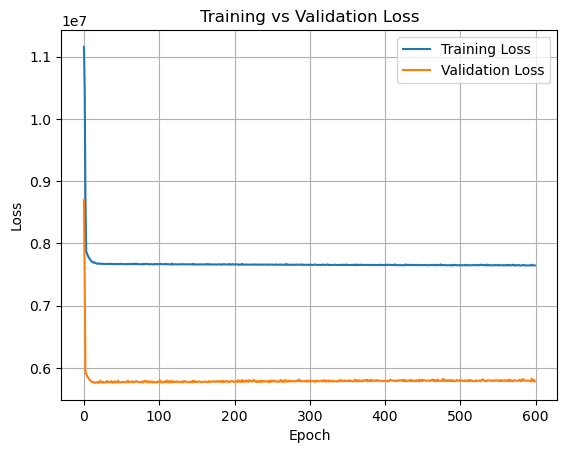

In [70]:
# Extract loss values
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the curve
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [71]:
# Evaluation
print("🔹 Feed-Forward NN")
print("RMSE:", np.sqrt(mean_squared_error(y_test, model.predict(X_test_scaled, verbose=0))))
print("MAE", mean_absolute_error(y_test, model.predict(X_test_scaled, verbose=0)))
print("R2 Score:", r2_score(y_test, model.predict(X_test_scaled, verbose=0)))

🔹 Feed-Forward NN
RMSE: 2426.331149456697
MAE 1482.0080153295087
R2 Score: -0.0032994482262520552


### Gamme regressor

In [104]:
from sklearn.linear_model import GammaRegressor

model = GammaRegressor(alpha=0.1, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

RMSE: 2423.837091488417
MAE 1500.391065042026
R² Score: -0.0012378986995187358
